In [50]:
import numpy as np
import pandas as pd

# Load the CSV file, ignoring dtype warnings by setting low_memory=False
df = pd.read_csv('position_velocity_data.csv', low_memory=False)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep = df['real_timestep_s'].values[0]

# Convert them to numpy arrays
# positions = [df[col].astype(float).values for col in position_cols]
# velocities = [df[col].astype(float).values for col in velocity_cols]
positions = np.array([df[col].astype(float).values for col in position_cols])
velocities = np.array([df[col].astype(float).values for col in velocity_cols])

# Optionally, convert to numpy arrays with shape (num_traces, num_points)
positions = np.array(positions)
velocities = np.array(velocities)

# Print the shapes to verify
print(f"Positions shape: {positions.shape}")
print(f"Velocities shape: {velocities.shape}")


Positions shape: (1, 16955996)
Velocities shape: (1, 16955996)


In [51]:
bin_num = 1000
fs = 1/(timestep*bin_num)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces = []
for trace in positions:
    series = bin_data(trace, bin_num)
    traces.append(series)

V_traces = []
for trace in velocities:
    series = bin_data(trace, bin_num)
    V_traces.append(series)

zero idx: [  330   621   647  1378  1413  1783  1795  2069  2313  2324  2809  2945
  3176  3331  3598  3689  3923  3951  4042  4095  4153  4787  5030  5327
  5386  5437  5664  5681  5889  6105  6394  6641  7007  7110  7239  7532
  7806  8002  8368  8442  8922  9279  9303  9337 10097 10299 10640 10965
 11345 12016 12201 12209 12293 12328 12602 12735 12898 13300 13725 14065
 14310 14351 14558 14729 14761 14797 14832 15148 15258 15301 16238 16381
 16666]


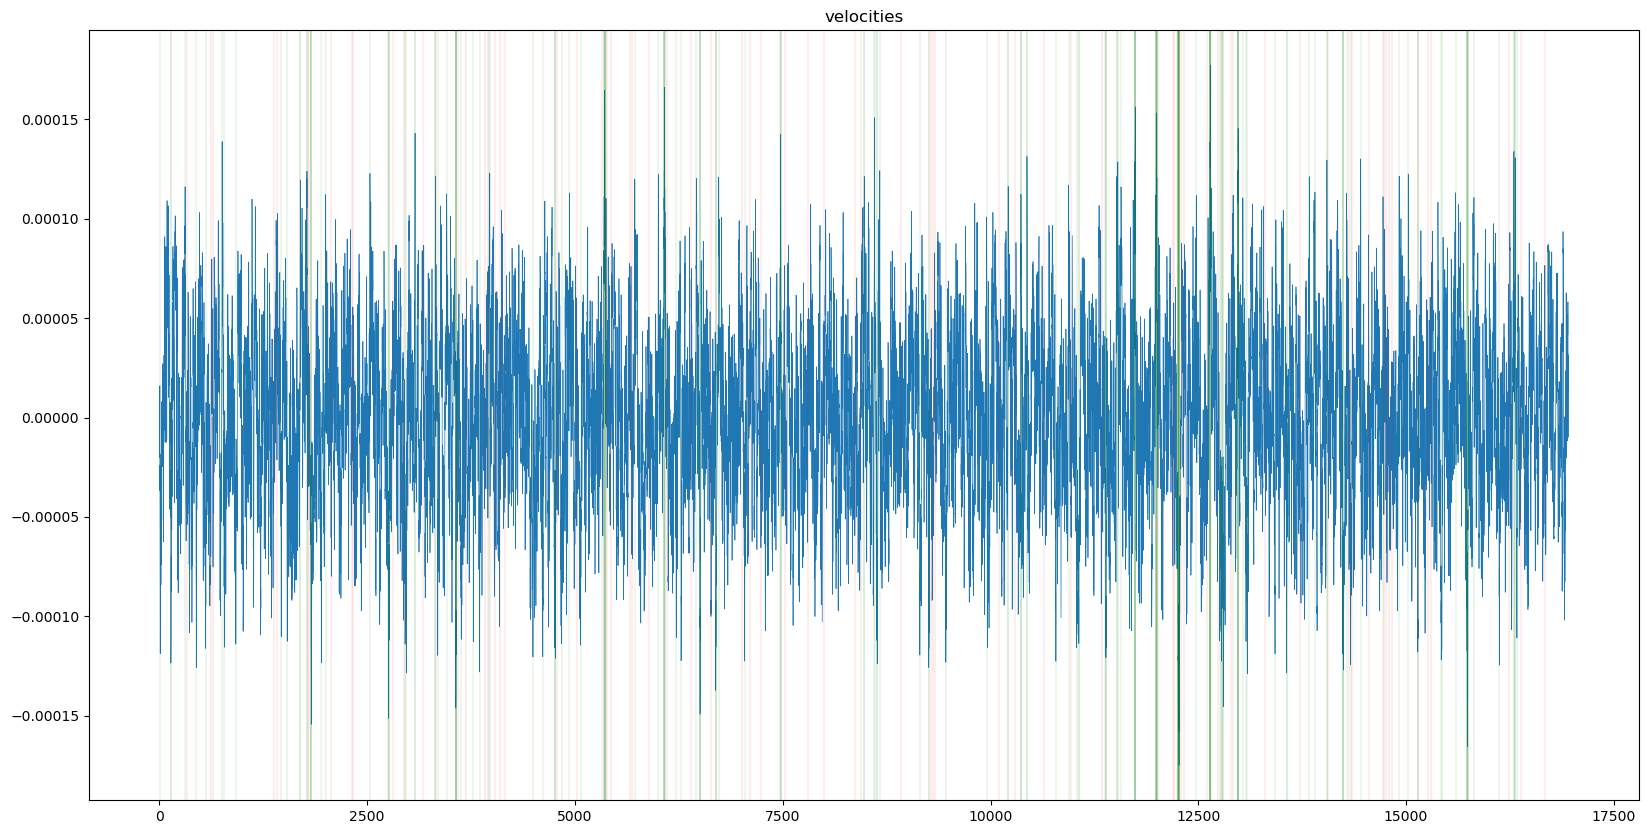

In [56]:
# Find spots where velocity is zero
import matplotlib.pyplot as plt

index_mult = 1#(timestep * sample_rate) * tao_c
x_c = 1

zero_idxs = []
high_idxs = []
for i in range(len(traces)):
    plt.figure(figsize=(20,10))
    # plt.plot([t * index_mult for t in range(len(positions[i]))], positions[i] * x_c, linewidth=0.5)
    plt.plot([t * index_mult for t in range(len(V_traces[i]))], V_traces[i], linewidth=0.5)

    tolerance = (.005*np.std(V_traces[i]))
    high_tolerance = (2.5*np.std(V_traces[i]))

    far_from_zero_indicies = np.where(abs(V_traces[i]) > high_tolerance)[0]
    close_to_zero_indices = np.where(abs(V_traces[i]) < tolerance)[0]

    print("zero idx: " + str(close_to_zero_indices))
    plt.title("velocities")
    # Draw vertical lines where values are close to zero
    for index in close_to_zero_indices:
        plt.axvline(x=index*index_mult, color='red', linestyle='-', linewidth=0.1)

    for index in far_from_zero_indicies:
        plt.axvline(x=index*index_mult, color='green', linestyle='-', linewidth=0.1)

    high_idxs.append(far_from_zero_indicies)
    zero_idxs.append(close_to_zero_indices)

In [57]:
def compute_msd(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd = [(time_trace[0]-time_trace[i])**2 for i in range(n)]
    return msd, lag_times

v at rand idx is -2.753796960016689e-05
v at rand idx is -3.364578880094241e-05
v at rand idx is 1.2272061588181644e-05
v at rand idx is -4.80869586416528e-05
v at rand idx is 3.9397745363897965e-05
v at rand idx is -3.9216495932928735e-05
v at rand idx is 5.4066610017616756e-05
v at rand idx is 2.5211929177203414e-05
v at rand idx is 2.3232512349775053e-05
v at rand idx is -2.6291232553150232e-05
v at rand idx is 6.559879040804822e-05
v at rand idx is 3.66361005721999e-05
v at rand idx is 4.865413886628482e-05
v at rand idx is 6.60240654014423e-05
v at rand idx is -6.839086908682426e-05
v at rand idx is 3.246319167562392e-05
v at rand idx is 3.430832318380073e-05
v at rand idx is -8.37761411998791e-05
v at rand idx is -4.831461569351366e-06
v at rand idx is -4.0570806743981765e-05
v at rand idx is -4.8736501566953087e-05
v at rand idx is -3.2961574672709835e-05
v at rand idx is 6.237939522291923e-05
v at rand idx is -6.966907291685991e-05
v at rand idx is -7.107929753804242e-05
v at r

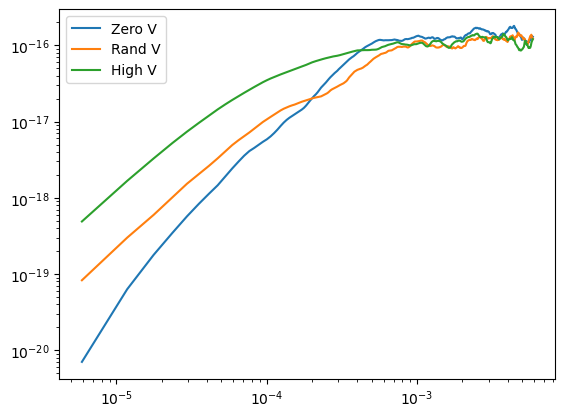

In [62]:
msd_len = 1000
lag_times = 0

import random

msds_zint = []
for i in range(len(traces)):
    for idx in zero_idxs[i]:
        if idx+msd_len < len(traces[i]):
            super_trace = traces[i][idx:idx+msd_len]
            msd, lag_times = compute_msd(super_trace, 1/fs)
            msds_zint.append(msd)

msds_rint = []
for i in range(len(traces)):
    for j in range(len(zero_idxs[i])):
        idx = random.randint(0,len(traces[i])-msd_len)
        print("v at rand idx is " + str(V_traces[i][idx]))
        reg_trace = traces[i][idx:idx+msd_len]
        msd2, lag_times = compute_msd(reg_trace, 1/fs)
        msds_rint.append(msd2)

msds_hint = []
for i in range(len(traces)):
    for idx in high_idxs[i]:
        if idx+msd_len < len(traces[i]):
            slow_trace = traces[i][idx:idx+msd_len]
            msd, lag_times = compute_msd(slow_trace, 1/fs)
            msds_hint.append(msd)

msds_zinta = np.mean(msds_zint, axis=0)
msds_rinta = np.mean(msds_rint, axis=0)
msds_hinta = np.mean(msds_hint, axis=0)

plt.plot(lag_times[1:], msds_zinta[1:], label="Zero V")
plt.plot(lag_times[1:], msds_rinta[1:], label="Rand V")
plt.plot(lag_times[1:], msds_hinta[1:], label="High V")
# plt.plot(lag_times[1:], 1e-3*lag_times[1:]**3, label="3")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
        

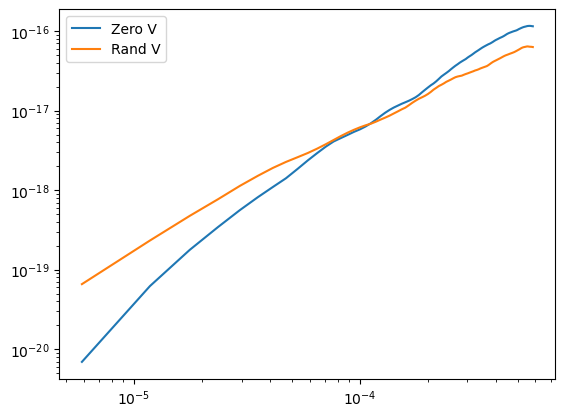

In [59]:

plt.plot(lag_times[1:], msds_zinta[1:], label="Zero V")
plt.plot(lag_times[1:], msds_rinta[1:], label="Rand V")
# plt.plot(lag_times[1:], 1e-3*lag_times[1:]**3, label="3")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
